In [1]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import tensorflow as tf
import gym
from matplotlib import pyplot as plt



# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
# gamma = 1-0.
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = True # resume from previous checkpoint?
# resume = False;
render = False
# render = True
backlen=20;

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(xrange(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}
def lookback(lst):
    lst = lst[-backlen:];
#     np.pad(lst,(20-lst.size,), 'constant', constant_values=0);
    if len(lst) != backlen:
        lst = [None]*(backlen-len(lst)) + lst;
    return(lst)

def time_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    grad = 0;
    for t in reversed(xrange(0, r.size)):
#         grad = grad * gamma + r[t] ;
        if r[t] != 0: 
            running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
            grad = 2 * (r[t] > 0) - 1; 
        running_add = running_add + grad;
        discounted_r[t] = running_add
    return discounted_r
def quickax():
    fig = plt.figure(figsize=[8,8])
    ax1 = fig.add_subplot(221)
    return ax1

* Initiliase topology
* set input and output
* set optimiser
* set routine


In [2]:
# tf.reset_default_graph()
from keras.layers import Input, Dense, convolutional,core,concatenate,Flatten,Reshape,Concatenate
from keras.models import Model,load_model
from keras.models import model_from_json
from keras import backend as K
from PGAgent import PGAgent
import keras

def quickax():
    fig = plt.figure(figsize=[8,8])
    ax1 = fig.add_subplot(221)
    return ax1
def savemodel(m,ModelFile):
    # serialize model to JSON
    model_json = m.to_json()
    with open(ModelFile+'.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(ModelFile+'.h5')
    pickle.dump(losshist,open(ModelFile+'.p', "wb"))
    print("Saved model to disk at "+ModelFile)
# savemodel(model,ModelFile)

# load json and create model
def loadmodel(ModelFile):
    global losshist,episode_number
    json_file = open(ModelFile+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(ModelFile+'.h5')
#     print("Saved model to disk at "+ModelFile)
    losshist = pickle.load(open(ModelFile+'.p', 'rb'))
    episode_number = len(losshist.losses);
    print("Model loaded from disk at "+ModelFile)
    return(loaded_model)
# model = loadmodel(ModelFile)
class LossCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
class LossHist():
    def __init__(self):
        self.losses=[];
    def add(self,n,loss):
        l = len(self.losses);
        if n == l+1:
            self.losses.append(loss);
        else:
            self.losses += [0]*(n-l);
            self.losses = self.losses[:n];
            self.losses[n-1] = loss;
            print('Loss history has changed ')
    def vis(self,ax):
        ax.plot(self.losses,'-');
        pass

def lossfunc(y_true,y_pred):
    return K.mean(K.mean( K.square( y_pred / (K.abs(y_true)+1) - 1)  )); 

def rlossfunc(truelst,y_pred):
    y_true,rsignal = truelst;
    loglik = K.log(y_true*(y_true - y_pred) + (1 - y_true)*(y_true + y_pred));
    loss = loglik * (- rsignal); 
    return K.mean(K.mean(loss)); 

# tpr=time_epr;
def decouple(tpr):
    tpr1=np.maximum(tpr,0);
    tpr2=np.minimum(tpr,0);
    tpr1[tpr1==0]=np.maximum(np.max(tpr1),20);
    tpr2[tpr2==0]=np.minimum(np.min(tpr2),-20);
    tpr2=-tpr2;
    time_epr = np.hstack([tpr1,tpr2])
    return(time_epr)


def calc_expt(eptpred,rd=np.array([[1,-1]])):
    prep = np.exp(-eptpred)
    z = np.expand_dims(np.sum(prep,axis = 1),1);
    rz = np.reciprocal(z)
#     p = prep * z,;
#     rd = np.array([[1,-1]]);
    expt = (np.sum(prep*rd,axis = 1)*rz.T).T;
    return expt


def merge_signal(epr,eptpred):
    rd = discount_rewards(epr);
    critic = calc_expt(eptpred);
    wt =np.expand_dims(np.array( [1, np.exp(-curr_loss)]),1);
    vct = np.array([epr,critic]).squeeze();
    signal = np.sum(vct*wt,axis=0)/np.sum(wt,axis=0);
    return np.expand_dims(signal,1 );

Using TensorFlow backend.


In [3]:
# model initialization
resume = 1;
# resume = True;
render = False;
render = True;
H=5;
k=4;
gamma = 0.99;
D1=80;D2=80;
D = 80 * 80 # input dimensionality: 80x80 grid

try:
    del model
except:    pass;
x_input = Input(shape=(D,));
po_input = Input(shape=(1,));
conv1 = convolutional.Conv2D(filters=H,
                             kernel_size=(k,k),
                            strides=(1,1),
                            padding='same',
                            activation='relu')(Reshape((80, 80,1))(x_input))
den1 = Flatten()(Dense(units=5*H,
             activation='relu')(conv1))

den1c = Concatenate()([den1,po_input]);

score = Dense(units=2,
              activation = 'relu')(den1c)

model = Model(inputs=[x_input,po_input], outputs=[score])



optimiser = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer='rmsprop',
              loss=lossfunc)

env = gym.make("Pong-v0")
observation = env.reset()

action_size = env.action_space.n
agent = PGAgent(D, action_size)



# aconv1 = convolutional.Conv2D(filters=H,
#                              kernel_size=(k,k),
#                             strides=(1,1),
#                             padding='same',
#                             activation='relu')(x_input)
# aden1 = Flatten()(Dense(units=5*H,
#              activation='relu')(aconv1))
# ascore = Dense(units=1,
#               activation = 'sigmoid')(aden1)

# model_actor = Model(inputs = [x_input,po_input], outputs=[ascore]);
# model_actor.compile(optimizer='rmsprop',
#               loss=rlossfunc)


history = LossCallback()
# log = model.fit([epx,epy], time_epr,callbacks=[history])
# loss = model.train_on_batch([epx,epy], time_epr)
# print(history.losses[-1])
# x = Dense(64, activation='relu')(x_input)
model.summary()

[2017-06-06 21:54:47,043] Making new env: Pong-v0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 80, 80)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 27, 32)         92192     
_________________________________________________________________
flatten_2 (Flatten)          (None, 864)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                55360     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 149,830
Trainable params: 149,830
Non-trainable params: 0
_________________________________________________________________
____

PGAgent.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (6, 6), kernel_initializer="he_uniform", activation="relu", padding="same", strides=(3, 3))`
  activation='relu', init='he_uniform'))
PGAgent.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="he_uniform", activation="relu")`
  model.add(Dense(64, activation='relu', init='he_uniform'))
PGAgent.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, kernel_initializer="he_uniform", activation="relu")`
  model.add(Dense(32, activation='relu', init='he_uniform'))


In [65]:
# xinput.shape
del model
del losshist

(0, 1.0300502315163613)

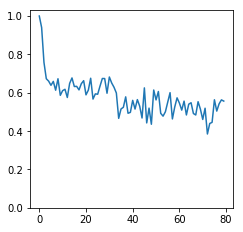

In [88]:
# losshist_temp=losshist;

ax = quickax();
losses = losshist.losses;
losshist = LossHist();
losshist.losses = losses;
losshist.vis(ax);
ax.set_ylim(bottom=0)

80

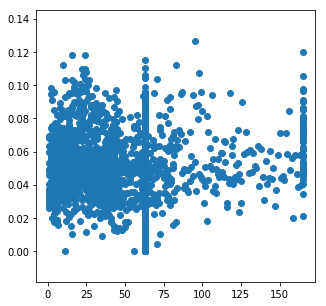

In [13]:
# discount_rewards(epdlogp)
x.size
%matplotlib inline
plt.close('all')
fig=plt.figure(figsize=[5,5])
ax1=plt.subplot()
# ax1.plot(time_epr)
# ax1.plot(discounted_epr)
ax1.scatter(abs(time_epr),eptpred)
# ax1.set_xlim([0, 200])
# ax1.set_xlim([800, 1000])
# ax1.set_ylim([-10, 000])
# ax1.imshow(eph[:500,:500].T)
time_epr.size
# tpreds.size
D1



In [7]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
ys=[];byss=[];rss=[];tpreds=[];
running_reward = None
reward_sum = 0
episode_number = 0;

ModelName = 'H5k4_agent_critic'
ModelFile = 'Models/'+ModelName+'.ckpt';
AgentName = 'pong';
AgentFile = 'Models/'+AgentName+'.h5'
LogName= 'Models/' + AgentName+'.log';
# LogFile =open(LogName,'a+');

render = False;
resume = 1;
batch_size=1;
learning_rate = 1e-2
optimiser = keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)
# episode_number = 0;

if 'losshist' in locals():
    pass
else:
    losshist = LossHist();

if True:
    
    agent = PGAgent(D, action_size)
    if resume:
        model = loadmodel(ModelFile)
        agent.load(AgentFile);
#         losshist=losshist_temp;
        print(losshist.losses[-5:])
        print(len(losshist.losses))
        
    model.compile(optimizer='rmsprop',
                  loss=lossfunc)
    
    episode_number = 0; ### only for test!
    while episode_number < 1:
        if render: env.render()

        # preprocess the observation, set input to network to be difference image
        cur_x = prepro(observation)
        diff_x = cur_x - prev_x if prev_x is not None else np.zeros(D)
        prev_x = cur_x
#         x = np.reshape(diff_x,[1,D1,D2,1]);
        x = np.expand_dims(diff_x,axis = 2).T;
#         x = diff_x.T
        
        # Sample action and label it 
#         aprob = 0.5;        
        action, prob = agent.act(x)
#         aprob = model_actor.predict(x);
#         action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
        y = 1 if action == 2 else 0 # a "fake label"
        
        # Run predictor
        tpred = model.predict([x,np.array([[y]])]);
#         tpred = model.predict({'input_1':x,'input_2':np.array([[y]])});
        
    
        # record various intermediates (needed later for backprop)
        xs.append(x) # observation
        ys.append(y)
        tpreds.append(tpred);
#         spreds.append(spred);

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)
        
        agent.remember(x, action, prob, reward)
        

        if done: # an episode finished
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys);
            epr = np.vstack(drs)
            eptpred=np.vstack(tpreds);
#             epspred=np.vstack()
            xs,hs,dlogps,drs,ys,tpreds = [],[],[],[],[],[] # reset array memory
            
            ## process reward on a per event basis
            tpr=time_rewards(epr);
            time_epr = decouple(tpr);
            
            ## train the critic networks 
            curr_loss = model.train_on_batch([epx,epy], time_epr)
            losshist.add(episode_number,curr_loss);
            
            ## train the actor network, with signal from critics weighted by the loss.
            critic = calc_expt(eptpred);
            rsignal = merge_signal(epr,eptpred)
            agent.train(rsignal);
#             model_actor.train_on_batch([epx,epy],rsignal*); ### finish this
            
            if episode_number % batch_size == 0:
                #accumulate gradient over batch where appropriate
                pass
   
            # boring book-keeping
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            logmsg='resetting env. episode %d reward total was %f. loss_func: %f' % (episode_number, reward_sum, curr_loss);
            print(logmsg);
#             with open(LogName,'a+') as LogFile:
#                 LogFile.write(logmsg+'\n')
            
            if episode_number % 10  == 9: 
                savemodel(model,ModelFile)
                agent.save(AgentFile)

            reward_sum = 0
            observation = env.reset() # reset env
            prev_x = None
            #     print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

[2017-06-06 21:55:35,223] Making new env: Pong-v0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1, 80, 80)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 27, 32)         92192     
_________________________________________________________________
flatten_5 (Flatten)          (None, 864)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                55360     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 149,830
Trainable params: 149,830
Non-trainable params: 0
_________________________________________________________________
Mode

In [10]:
agent

(1142, 1)

In [11]:
# agent.state
try:
    del PGAgent;
except: pass
x.shape

(1, 6400)

In [4]:
# discount_rewards(epdlogp)

# z=x;
# z[:,0]= np.convolve(x[:,0], [1,-2,1], mode='same')
# z[:,1]= np.convolve(x[:,1], [1,-2,1], mode='same')
# eptpred = z;
deptpred = np.copy(eptpred);
x= np.copy(eptpred);

deptpred[:,0] = np.convolve(x[:,0], [0,-1,1], mode='same');
deptpred[:,1] = np.convolve(x[:,1], [0,-1,1], mode='same');
x[:,0] = np.convolve(x[:,0], [1./3,1./3,1./3], mode='same');
x[:,1] = np.convolve(x[:,1], [1./3,1./3,1./3], mode='same');
# deptpred[:,0] = np.convolve(abs(deptpred[:,0]), [1./3,1./3,1./3], mode='same');
# deptpred[:,1] = np.convolve(abs(deptpred[:,1]), [1./3,1./3,1./3], mode='same');

# deptpred[:,1] = np.convolve(x[:,1], [0,-1,1], mode='same');



def calc_expt(eptpred,rd=np.array([[1,-1]])):
    prep = np.exp(-eptpred)
    z = np.expand_dims(np.sum(prep,axis = 1),1);
    rz = np.reciprocal(z)
#     p = prep * z,;
#     rd = np.array([[1,-1]]);
    expt = (np.sum(prep*rd,axis = 1)*rz.T).T;
    return expt


def merge_signal(epr,eptpred):
    rd = discount_rewards(epr);
    critic = calc_expt(eptpred);
    wt =np.expand_dims(np.array( [1, np.exp(-curr_loss)]),1);
    vct = np.array([epr,critic]).squeeze();
    signal = np.sum(vct*wt,axis=0)/np.sum(wt,axis=0);
    return signal 
# signal
# x

NameError: name 'eptpred' is not defined

In [234]:
vct.shape
# wt.shape
# epr.shape

AttributeError: 'builtin_function_or_method' object has no attribute 'shape'

(-0.1, 2.1000000000000001)

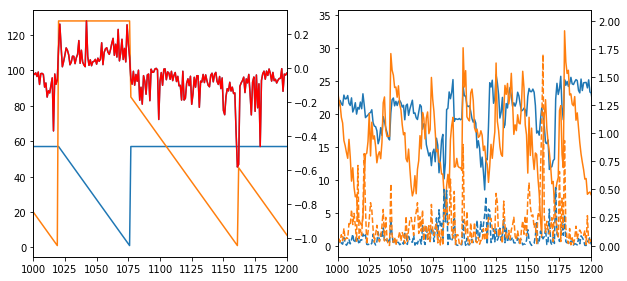

In [82]:
# import scipy.signal.convolve2d as convolve2d
from scipy.signal import convolve2d
%matplotlib inline
plt.close('all')

fig=plt.figure(figsize=[10,10])
ax1=plt.subplot(221)

ax1.plot(time_epr)
# ax1.plot(eptpred)

ax1b=ax1.twinx()
ax1b.plot(rsignal)


# ax1b.plot(expt)

# xcritic= np.convolve(critic, [0,-1,1], mode='same');

# ax1.plot(xcritic)

# ax1.plot(eptpred,'-')
# ax1.plot(x,'-')


ax2=plt.subplot(222)
ax2b=ax2.twinx();
# ax2.plot(eptpred[1:,: ])
ax2.plot(eptpred)

def merge_signal(epr,eptpred):
    x = eptpred;
    x_diff = convolve2d(x,[[0],[-1],[1]],mode='same');
    x_mean = convolve2d(x,[[0],[.5],[.5]],mode='same');
    x_avg = np.mean(abs(x_diff)/x_mean,axis = 1,keepdims = 1);
    rsign = discount_rewards(epr);
    rsignal = (x_avg * rsign);
    return rsignal


x = eptpred;
x_diff = convolve2d(x,[[0],[-1],[1]],mode='same');
x_mean = convolve2d(x,[[0],[.5],[.5]],mode='same');
x_sum = np.sum(abs(x_diff)/x_mean,axis = 1);
# ax1b.plot(x_sum)
rsignal = merge_signal(epr,eptpred);
ax1b.plot(rsignal,'r');
ax2b.plot(abs(x_diff)/x_mean,'--')
# ax2b.plot(np.diff(eptpred[:,0],axis=0,n=1)/eptpred[:0,],'--')

# ax1.plot(eptpred[:,1])

# ax2.plot(eptpred[:-1,1])
# ax2b.plot(abs(deptpred[:,1])/x[:,1],'--r')
# ax2.plot(eptpred[:-1,0])
# ax2b.plot(abs(deptpred[:,0])/x[:,0],'--r')

# ax1.plot(np.sign(-(epspred-.5))*2*(eptpred-1))

# ax1.plot(discounted_epr)
# ax1.scatter(abs(time_epr),eptpred)
# ax1.set_xlim([0, 500])
# ax1.set_xlim([500,700])
ax1.set_xlim([1000,1200])

# ax1.set_ylim(top = 20)
# ax2.set_xlim([500,700])
# ax2.set_xlim([600, 850])
ax2.set_xlim([1000,1200])
# ax2b.set_ylim(top =1.25)
ax2b.set_ylim(bottom =-.1)



# ax1.imshow(eph[:500,:500].T)
# tpreds.size

In [76]:
x = eptpred;
x_diff = convolve2d(x,[[0],[-1],[1]],mode='same');
x_mean = convolve2d(x,[[0],[.5],[.5]],mode='same');
x_avg = np.mean(abs(x_diff)/x_mean, axis = 1,keepdims = 1 );
rsign = discount_rewards(epr);
rsignal = (x_avg * rsign);
rsignal.shape

# x_avg.shape

(1207, 1)

In [19]:
time_epr.shape
# print(time_epr.ravel())
# time_epr
# tpreds
# H
# np.expand_dims(epx,1).shape
# curr_loss = sess.run(loss,feed_dict={xinput: epx, input_y: epy, rtime: time_epr});
# epx.shape
# tf.reshape(epy);
# D*H
# oSaver = tf.train.Saver()
# print(sess.run(score,feed_dict={xinput: epx, input_y: epy, rtime: time_epr}))
# oSess = sess
# oSaver.save(oSess, ModelFile)

(1631, 2)